In [47]:
import math
import time

import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import optax 

from typing import Sequence, Callable

import equinox as eqx

In [48]:
class FNN(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, in_size, out_size, width_size, depth, *, key):
        self.mlp = eqx.nn.MLP(
            in_size, out_size, width_size=width_size, depth=depth, key=key
        )

    def __call__(self, t, x, train: bool = True):
        y, f_vjp = jax.vjp(lambda x: self.mlp(jnp.concatenate([t, x])), x)
        dudx = f_vjp(jnp.ones(y.shape))
        return y, dudx[0]

In [49]:
class FBSDEStep(eqx.Module):
    unet: FNN
    noise_size: int
    mu_fn: Callable = eqx.static_field()
    sigma_fn: Callable = eqx.static_field()
    phi_fn: Callable = eqx.static_field()

    def __init__(self, in_size, out_size, width_size, depth, noise_size, key):
        self.unet = FNN(in_size=in_size, out_size=out_size, width_size=width_size, depth=depth, key=key)
        def mu_fn(t, X, Y, Z):
            del t, Y, Z
            return jnp.zeros_like(X)

        def sigma_fn(t, X, Y):
            del t, Y
            return 0.4 * X

        def phi_fn(t, X, Y, Z):
            del t
            return 0.05 * (Y - jnp.sum(X * Z, keepdims=True))
        
        self.mu_fn = mu_fn
        self.sigma_fn = sigma_fn
        self.phi_fn = phi_fn
        self.noise_size = noise_size
        

    def u_and_dudx(self, t, x):
        return self.unet(t, x)

    def __call__(self, carry, inp):
        # `t` and `W` are (batch_size, num_timestep, dim)
        # it have input data across iterations 

        (i, t0, dt, x0, y0, z0, key) = carry

        key, key2 = jrandom.split(key)

        # use `i` to index input data
        curr_t = jnp.full((1, ), t0 + i * dt)
        next_t = jnp.full((1, ), t0 + (i + 1) * dt)

        dW = jrandom.normal(key, (self.noise_size, )) * jnp.sqrt(dt)

        x1 = x0 + self.mu_fn(curr_t, x0, y0, z0) * dt + \
                self.sigma_fn(curr_t, x0, y0) * dW
    
        
        y1_tilde = y0 + self.phi_fn(curr_t, x0, y0, z0) * dt + \
            jnp.sum(z0 * self.sigma_fn(curr_t, x0, y0) * dW, keepdims=True)
        
        y1, z1 = self.unet(next_t, x1)

        carry = (i+1, t0, dt, x1, y1, z1, key2)
        outputs = (x1, y1_tilde, y1)
        return carry, outputs

In [50]:
class NeuralFBSDE(eqx.Module):
    # u_net: ModuleDef
    step: FBSDEStep
    # equ_problem: Any
    
    def __init__(self, in_size, out_size, width_size, depth, noise_size, key):
        self.step = FBSDEStep(in_size, out_size, width_size, depth, noise_size, key)

    def __call__(self, x0, t0, dt, num_timesteps, unroll=1, key=jrandom.PRNGKey(0)):
        
        y0, z0 = self.step.u_and_dudx(t=jnp.zeros((1, )), x=x0)

        carry = (0, t0, dt, x0, y0, z0, key)

        def step_fn(carry, inp=None):
            return self.step(carry, inp)
        
        (carry, output) = jax.lax.scan(step_fn, carry, None, length=num_timesteps, unroll=unroll)
        return (carry, output)

In [51]:
batch_size = 24
dim = 100
num_timesteps = 50

@jax.jit
def sum_square_error(y, y_pred):
    """Computes the sum of square error."""
    return jnp.sum(jnp.square(y - y_pred))

def fetch_minibatch(rng):  # Generate time + a Brownian motion
    T = 1.0
    M = batch_size
    N = num_timesteps
    D = dim

    dt = T / N * jnp.ones((M, 1))
    dW = jnp.sqrt(T / N) * jrandom.normal(rng, shape=(M, N, D))

    return dt, dW

In [55]:
def g_fn(X):
    return jnp.sum(X ** 2, axis=-1, keepdims=True)

def dg_fn(X):
    y, vjp_func = jax.vjp(g_fn, X)
    return vjp_func(jnp.ones(y.shape))[0]


@eqx.filter_jit
def train_step(model, x0, t0, dt, num_timesteps, optimizer, opt_state, unroll=1, key=jrandom.PRNGKey(0)):
    # batch_size = model.batch_size
    # t, W = data
    @eqx.filter_jit
    def loss_fn(model):
        loss = 0.0
        
        out_carry, out_val = jax.vmap(model, in_axes=(0, None, None, None, None, 0))(x0, t0, dt, num_timesteps, unroll, key)
        
        (_, _, _, x_final, y_final, z_final, _) = out_carry
        (x, y_tilde_list, y_list) = out_val
        
        loss += sum_square_error(y_tilde_list, y_list)
        loss += sum_square_error(y_final, g_fn(x_final))
        loss += sum_square_error(z_final, dg_fn(x_final))

        return (loss, y_list)

    (loss, y), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model)
    
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    
    return loss, model, opt_state, y

start_time = time.time()
iter_time_list = []

learning_rate = 1e-3
rng = jrandom.PRNGKey(0)

model = NeuralFBSDE(in_size=dim + 1, out_size=1, width_size=16, depth=4, noise_size=dim, key=rng)

x0 = jnp.array([1.0, 0.5] * int(dim / 2))
x0 = jnp.broadcast_to(x0, (batch_size, dim))


optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

unroll = 1
verbose = True
num_iters = 5000


for i in range(num_iters):
    rng, _ = jrandom.split(rng)
    bm_key = jax.random.split(rng, batch_size)
    # data = fetch_minibatch(rng)
    # jax.vmap(model, in_axes=[0, None, None, None, None, None])(x0, 0.0, 0.01, 100, unroll, rng)
    loss, model, loss, y_pred = train_step(model, x0, 0.0, 0.02, 50, optimizer, opt_state, unroll, bm_key)

    if verbose:
        if i == 0:
            compile_time = time.time()
            iter_time = time.time()
        if i % 100 == 0 and i > 0:
            print(f"y: {y_pred[0, 0, 0]}")

if verbose:
    # output = output + str(num_iters) + ","
    # output = output + str(np.mean(iter_time_list)) + ","
    print(f"compile: {compile_time - start_time}")
    print(f"run: {time.time() - compile_time}")
    # output = output + str(compile_time - start_time) + ','
    # output = output + str(time.time() - compile_time)

    # print(f"num_iteration: {num_iters}")
    # print(f"unroll: {unroll}")
    # print(f"batch_size: {batch_size}")
    # print(f"total_time: {time.time() - start_time}")
    # print(f"iter100_time: {np.mean(iter_time_list)}")
    # print(f"compile_time: {(compile_time - start_time)}")

y: 17.93117904663086


[[-0.16632776 -0.1656122 ]
 [-0.16686551 -0.16530134]
 [-0.16715765 -0.16480295]
 [-0.16731824 -0.16509014]
 [-0.1672329  -0.16528979]
 [-0.16681583 -0.16580884]
 [-0.16652995 -0.16658425]
 [-0.167188   -0.16703442]
 [-0.16716543 -0.16730793]
 [-0.16585356 -0.16676229]
 [-0.16485111 -0.16604361]
 [-0.16468729 -0.16514781]
 [-0.16481484 -0.16583365]
 [-0.16487816 -0.1653873 ]
 [-0.1654671  -0.16544305]
 [-0.16513202 -0.1661642 ]
 [-0.16432756 -0.16597682]
 [-0.16345847 -0.16608396]
 [-0.16425924 -0.16545688]
 [-0.16476148 -0.1654205 ]
 [-0.16484442 -0.16542645]
 [-0.16382508 -0.16582458]
 [-0.16165897 -0.16563353]
 [-0.16113581 -0.16551962]
 [-0.16249874 -0.16519831]
 [-0.16107513 -0.1645197 ]
 [-0.1614825  -0.16516598]
 [-0.16204348 -0.16561332]
 [-0.16161582 -0.16557053]
 [-0.16208279 -0.16577326]
 [-0.16274153 -0.16599889]
 [-0.16186617 -0.16684943]
 [-0.16162336 -0.16683415]
 [-0.1612159  -0.16691294]
 [-0.16265763 -0.16681689]
 [-0.16266453 -0.16655526]
 [-0.16189367 -0.166342  ]
 

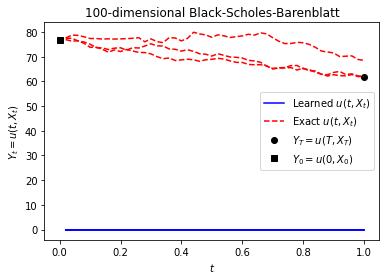

In [53]:
import matplotlib.pyplot as plt

def u_exact(t, X): # (N+1) x 1, (N+1) x D
    r = 0.05
    sigma_max = 0.4
    return jnp.exp((r + sigma_max**2)*(1.0 - t))*jnp.sum(X**2, 1, keepdims = True)

samples = fetch_minibatch(rng)
_, W_test = samples

Dt = jnp.concatenate([jnp.zeros((batch_size, 1), dtype=jnp.float32), jnp.ones((batch_size, num_timesteps)) * 1.0 / num_timesteps], axis=1).reshape((batch_size, num_timesteps+1, 1))
t_test = jnp.cumsum(Dt, axis=1)  # M x (N+1) x 1

rng = jrandom.split(rng, batch_size)
out_carry, out_val = jax.vmap(model, in_axes=(0, None, None, None, None, 0))(x0, 0.0, 0.02, num_timesteps, unroll, rng)
_, (X_pred, y_tilde_list, Y_pred) = out_carry, out_val

# X_pred = jnp.transpose(X_pred, (1, 0, 2))
# print(X_pred.shape)
# Y_pred = jnp.transpose(Y_pred, (1, 0, 2))

Y_test = jnp.reshape(u_exact(jnp.reshape(t_test[0:batch_size, 0:num_timesteps,:],[-1,1]), jnp.reshape(X_pred,[-1,dim])),[batch_size,-1,1])

n_samples = 3
    
plt.figure()
plt.plot(t_test[0:1,1:,0].T, Y_pred[0:1,:,0].T, 'b', label='Learned $u(t,X_t)$')
plt.plot(t_test[0:1,1:,0].T, Y_test[0:1,:,0].T, 'r--', label='Exact $u(t,X_t)$')
plt.plot(t_test[0:1,-1,0], Y_test[0:1,-1,0], 'ko', label='$Y_T = u(T,X_T)$')

plt.plot(t_test[1:n_samples,1:,0].T, Y_pred[1:n_samples,:,0].T,'b')
plt.plot(t_test[1:n_samples,1:,0].T,Y_test[1:n_samples,:,0].T,'r--')

print(Y_pred[1:n_samples,:,0].T)
print(Y_test[1:n_samples,:,0].T)
# plt.plot(t_test[1:n_samples,1:,0],Y_test[1:n_samples,-1,0],'ko')

plt.plot([0],Y_test[0,0,0],'ks',label='$Y_0 = u(0,X_0)$')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title('100-dimensional Black-Scholes-Barenblatt')
plt.legend()



In [54]:
# from functools import partial


# t = jnp.ones((batch_size, 1))
# x = jnp.ones((batch_size, dim))

# key = jrandom.PRNGKey(0)
# u_net = FNN(in_size=dim + 1, out_size=1, width_size=16, depth=4, key=key)
# y = jax.vmap(u_net)(t, x)

# cell = FBSDECell(FNN, 0.1, in_size=dim + 1, out_size=1, width_size=16, depth=4, key=key)
# y_cell = jax.vmap(cell.u_and_dudx)(t, x)

# fbsde = FBSDE(FBSDECell, FNN, 0.1, in_size=dim + 1, out_size=1, width_size=16, depth=4, key=key)

# x0 = jnp.array([[1.0, 0.5] * int(dim / 2)])
# x0 = jnp.broadcast_to(x0, (batch_size, dim))
# dW = jnp.sqrt(1.0 / 10) * jrandom.normal(key, shape=(batch_size, 10, dim))


# ys = jax.vmap(fbsde)(x0, dW)

